## **Proximal Policy Optimization (PPO)**
Pavlos Ntais - 1115202100122

### **Import Libraries**

In [8]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy

In [9]:
seed_n = 42
np.random.seed(seed_n)

In [10]:
rewards_list = list()

episodes       = 605
print_per_iter = 10

class EpisodeRewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(EpisodeRewardCallback, self).__init__(verbose)
        self.episode_rewards        = list()
        self.current_episode_reward = 0
        self.curr_episode           = 0
        self.verbose                = True

    def _on_step(self) -> bool:
        global rewards_list, print_per_iter
        rewards = self.locals["rewards"]
        dones   = self.locals["dones"]

        self.current_episode_reward += rewards[0]

        # print the total reward
        if dones[0]:
            if self.verbose and self.curr_episode % print_per_iter == 0 and self.curr_episode != 0:
                avg_reward = np.mean(rewards_list[-print_per_iter:])
                print(f"Episode {self.curr_episode}, Reward: {avg_reward:.2f}")
                            
            self.episode_rewards.append(self.current_episode_reward)
            rewards_list.append(self.current_episode_reward)
            self.current_episode_reward = 0
            self.curr_episode += 1
        
        return True

In [11]:
# create the environment
env = gym.make('MountainCar-v0')

def set_rand_env(env, seed=seed_n):
    env.action_space.seed(seed)
    state, _ = env.reset(seed=seed)

set_rand_env(env)

In [12]:
# wrap the environment for Stable-Baselines3
vec_env = DummyVecEnv([lambda: env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# create the PPO model
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=0,
    learning_rate=3e-4,
    n_steps=1024,
    batch_size=32,
    gae_lambda=0.9,
    gamma=0.99,
    n_epochs=20,
    clip_range=0.2,
    seed=seed_n
)

model.learn(total_timesteps=episodes*200, callback=EpisodeRewardCallback())

Episode 10, Reward: -200.00
Episode 20, Reward: -200.00
Episode 30, Reward: -200.00
Episode 40, Reward: -200.00
Episode 50, Reward: -200.00
Episode 60, Reward: -196.00
Episode 70, Reward: -193.50
Episode 80, Reward: -179.60
Episode 90, Reward: -177.50
Episode 100, Reward: -178.40
Episode 110, Reward: -165.60
Episode 120, Reward: -162.80
Episode 130, Reward: -163.60
Episode 140, Reward: -141.90
Episode 150, Reward: -147.70
Episode 160, Reward: -140.20
Episode 170, Reward: -135.50
Episode 180, Reward: -130.70
Episode 190, Reward: -132.90
Episode 200, Reward: -128.90
Episode 210, Reward: -127.50
Episode 220, Reward: -130.90
Episode 230, Reward: -128.40
Episode 240, Reward: -128.80
Episode 250, Reward: -126.70
Episode 260, Reward: -121.50
Episode 270, Reward: -122.00
Episode 280, Reward: -129.90
Episode 290, Reward: -112.50
Episode 300, Reward: -136.30
Episode 310, Reward: -120.20
Episode 320, Reward: -117.20
Episode 330, Reward: -120.40
Episode 340, Reward: -119.10
Episode 350, Reward: -1

In [15]:
def compute_rolling_average(rewards, window_size=print_per_iter):
    """
    Computes the rolling average of rewards.

    Args:
        rewards (list): List of rewards per episode.
        window_size (int): Number of episodes to average over.

    Returns:
        list: Rolling average rewards.
    """
    
    return [
        np.mean(rewards[max(0, i - window_size + 1):i + 1])
        for i in range(len(rewards))
    ]

def plot_single_reward(rewards, title, window_size=print_per_iter):
    """
    Plots the average rewards (rolling average) for a single run.

    Args:
        rewards (list): List of rewards for each episode.
        title (str): Title of the graph.
        window_size (int): Number of episodes for rolling average.
    """
    
    avg_rewards = compute_rolling_average(rewards, window_size=window_size)
    
    plt.figure(figsize=(12, 6))
    plt.plot(avg_rewards)
    
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

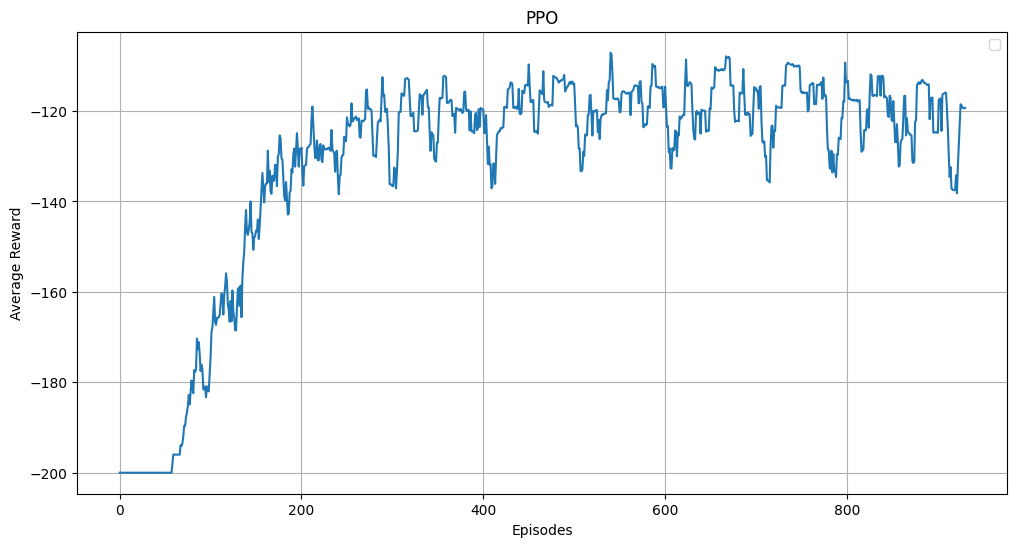

Mean reward: -110.6 +/- 1.2806248474865698


In [17]:
plot_single_reward(rewards_list, "PPO")
mean_reward, std_reward = evaluate_policy(model, vec_env, n_eval_episodes=10, deterministic=True)
print(f"Mean reward: {mean_reward} +/- {std_reward}")